# 3. Model Training 

## 3.1. Movement Data
Starting first with trying to predict User using statistical features of movement data, and testing different time intervels and it's effect on the accuracy of the results

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
%matplotlib inline

# importing Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB

# importing from sklearn the evaluation metrics for classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

# import tqdm to show a smart progress meter
from tqdm.notebook import trange,tqdm

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv')
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv')

In [3]:
X = mov_slow.drop(columns=['Unnamed: 0', 'ID'])
y = mov_slow['ID']
fast_X = mov_fast.drop(columns=['Unnamed: 0', 'ID'])
fast_y = mov_fast['ID']
unique_minutes = mov_slow['time_interval'].unique()

# Split data based on selected minutes
X_train = X[X['time_interval'].isin(unique_minutes[:8])]
y_train = y[X['time_interval'].isin(unique_minutes[:8])]

X_test = X[X['time_interval'].isin(unique_minutes[8:10])]
y_test = y[X['time_interval'].isin(unique_minutes[8:10])]

# Drop the 'minute' column from X_train and X_test as it's no longer needed for training/testing
X_train = X_train.drop(columns=['time_interval'])
X_test = X_test.drop(columns=['time_interval'])
fast_X = fast_X.drop(columns=['time_interval'])

print("Size of the training set: ", X_train.shape)
print("Size of the slow testing set: ", X_test.shape)
print("Size of the fast testing set: ", fast_X.shape)

Size of the training set:  (2877, 612)
Size of the slow testing set:  (720, 612)
Size of the fast testing set:  (3600, 612)


In [4]:
classifiers = [['SVC',SVC(kernel="rbf", C=0.025, probability=True, random_state=SEED)],
               ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=SEED)],
              ["LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()],
              ['DecisionTreeClassifier',DecisionTreeClassifier(random_state=SEED)],
              ['KNeighborsClassifier', KNeighborsClassifier()],
              ['RandomForestClassifier', RandomForestClassifier(random_state=SEED)],
              ['MLPClassifier',MLPClassifier(random_state=SEED)],
              ['AdaBoostClassifier',AdaBoostClassifier(random_state=SEED)],
              ['GaussianNB', GaussianNB()],
              ['QuadraticDiscriminantAnalysis',QuadraticDiscriminantAnalysis(store_covariance=True)],
              ['LogisticRegression', LogisticRegression(random_state=SEED)],
              ['XGBClassifier', XGBClassifier(random_state=SEED)],
              ['BernoulliNB', BernoulliNB()]]

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()

def evaluate_classifiers(classifiers, X_train,y_train,X_test,y_test,fast_X,fast_y):
    models = []
    best_score = 0 
    best_model = None
    cm = None
    Accuracy_set = pd.DataFrame(index=None, columns=['Model','Accuracy(Train)','Accuracy(Test)','Accuracy(Fast)','F1(Train)','F1(Test)', 'Precision(Train)','Precision(Test)', 'Recall(Train)','Recall(Test)', 'Log_loss(Train)','Log_loss(Test)'])
    for i in tqdm(range(len(classifiers))):
        name = classifiers[i][0]
        model = classifiers[i][1]

        model.fit(X_train,y_train)

        y_train_predicted = model.predict(X_train)
        y_test_predicited = model.predict(X_test)

        accuracy_train = accuracy_score(y_train, y_train_predicted)
        accuracy_test = accuracy_score(y_test, y_test_predicited)
        accuracy_fast = accuracy_score(fast_y, model.predict(fast_X))


        f1_Score_train = f1_score(y_train, y_train_predicted,average='micro')
        f1_Score_test = f1_score(y_test, y_test_predicited,average='micro')

        precision_score_train = precision_score(y_train, y_train_predicted,average='micro')
        precision_score_test = precision_score(y_test, y_test_predicited,average='micro')

        recall_score_train = recall_score(y_train, y_train_predicted,average='micro')
        recall_score_test = recall_score(y_test, y_test_predicited,average='micro')

        log_loss_train = log_loss(y_train, model.predict_proba(X_train))
        log_loss_test = log_loss(y_test, model.predict_proba(X_test))

        # store the models
        models.append((name,accuracy_test,model))

        if accuracy_test > best_score:
            best_model = model
            best_score = accuracy_test
            cm = confusion_matrix(y_test, y_test_predicited)

        Accuracy_set = Accuracy_set.append(pd.Series({'Model':name, 'Accuracy(Train)':accuracy_train,'Accuracy(Test)':accuracy_test,'Accuracy(Fast)':accuracy_fast , 'F1(Train)':f1_Score_train,'F1(Test)':f1_Score_test,'Precision(Train)':precision_score_train,'Precision(Test)':precision_score_test,'Recall(Train)':recall_score_train,'Recall(Test)':recall_score_test,'Log_loss(Train)':log_loss_train,'Log_loss(Test)':log_loss_test}),ignore_index=True )
    return Accuracy_set, models, best_model,cm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
Accuracy_set, models, best_model,cm = evaluate_classifiers(classifiers, X_train,y_train,X_test,y_test,fast_X,fast_y)
Accuracy_set.sort_values(by='Accuracy(Test)').style.background_gradient(cmap= plt.cm.Blues)

  0%|          | 0/13 [00:00<?, ?it/s]

,Model,Accuracy(Train),Accuracy(Test),Accuracy(Fast),F1(Train),F1(Test),Precision(Train),Precision(Test),Recall(Train),Recall(Test),Log_loss(Train),Log_loss(Test)
9,QuadraticDiscriminantAnalysis,1.000000,0.040278,0.016111,1.000000,0.040278,1.000000,0.040278,1.000000,0.040278,0.000000,33.147631
7,AdaBoostClassifier,0.090024,0.102778,0.033889,0.090024,0.102778,0.090024,0.102778,0.090024,0.102778,3.225526,3.205683
12,BernoulliNB,0.179006,0.113889,0.040278,0.179006,0.113889,0.179006,0.113889,0.179006,0.113889,4.007998,4.112027
0,SVC,0.610706,0.470833,0.042778,0.610706,0.470833,0.610706,0.470833,0.610706,0.470833,4.105756,4.104475
4,KNeighborsClassifier,0.838373,0.598611,0.035000,0.838373,0.598611,0.838373,0.598611,0.838373,0.598611,0.458866,6.745123
8,GaussianNB,0.887035,0.673611,0.029722,0.887035,0.673611,0.887035,0.673611,0.887035,0.673611,3.276179,10.428456
3,DecisionTreeClassifier,1.000000,0.743056,0.049444,1.000000,0.743056,1.000000,0.743056,1.000000,0.743056,0.000000,8.874547
2,LinearDiscriminantAnalysis,0.990268,0.759722,0.005278,0.990268,0.759722,0.990268,0.759722,0.990268,0.759722,0.065779,4.021916
10,LogisticRegression,0.985054,0.812500,0.045556,0.985054,0.812500,0.985054,0.812500,0.985054,0.812500,0.328119,0.771322
6,MLPClassifier,0.995134,0.820833,0.050278,0.995134,0.820833,0.995134,0.820833,0.995134,0.820833,0.064327,0.685108


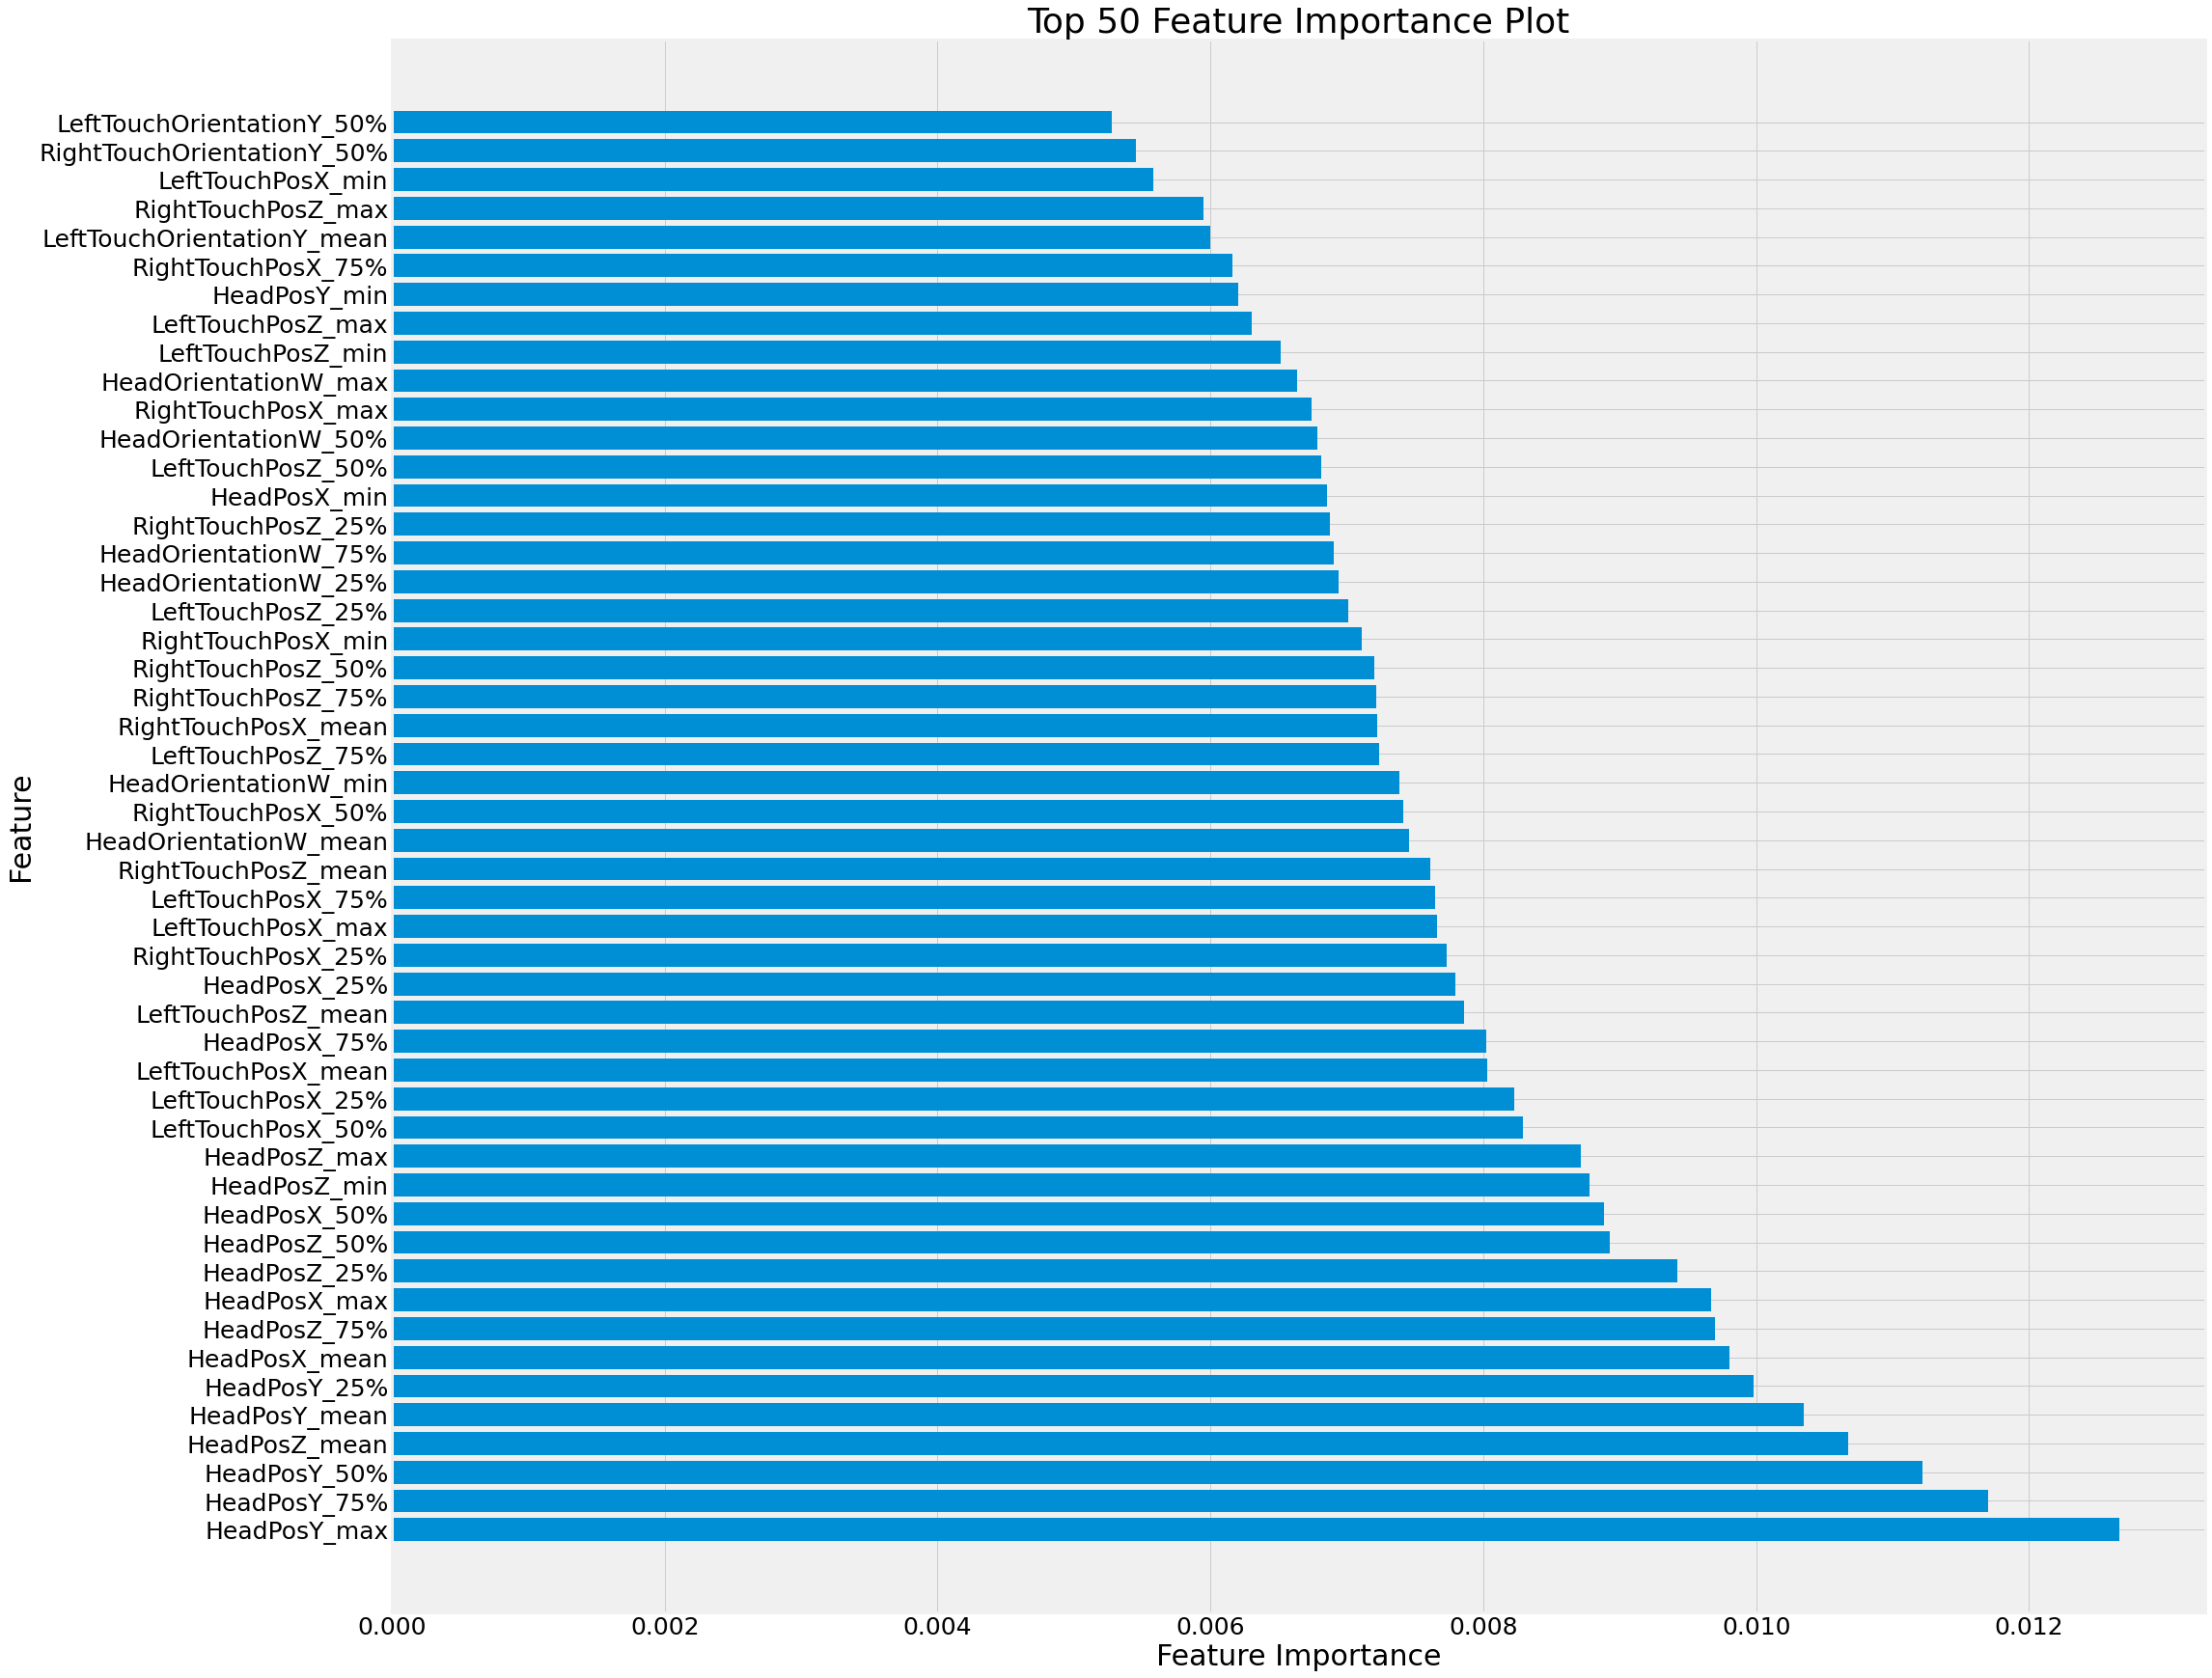

In [7]:
# Plotting feature importance if the best model is a tree-based model
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importance and names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Select top 50 features
top_features = importance_df.head(50)

plt.rcParams.update({'font.size': 25})  
plt.figure(figsize=(30,30))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importance Plot')
plt.show()

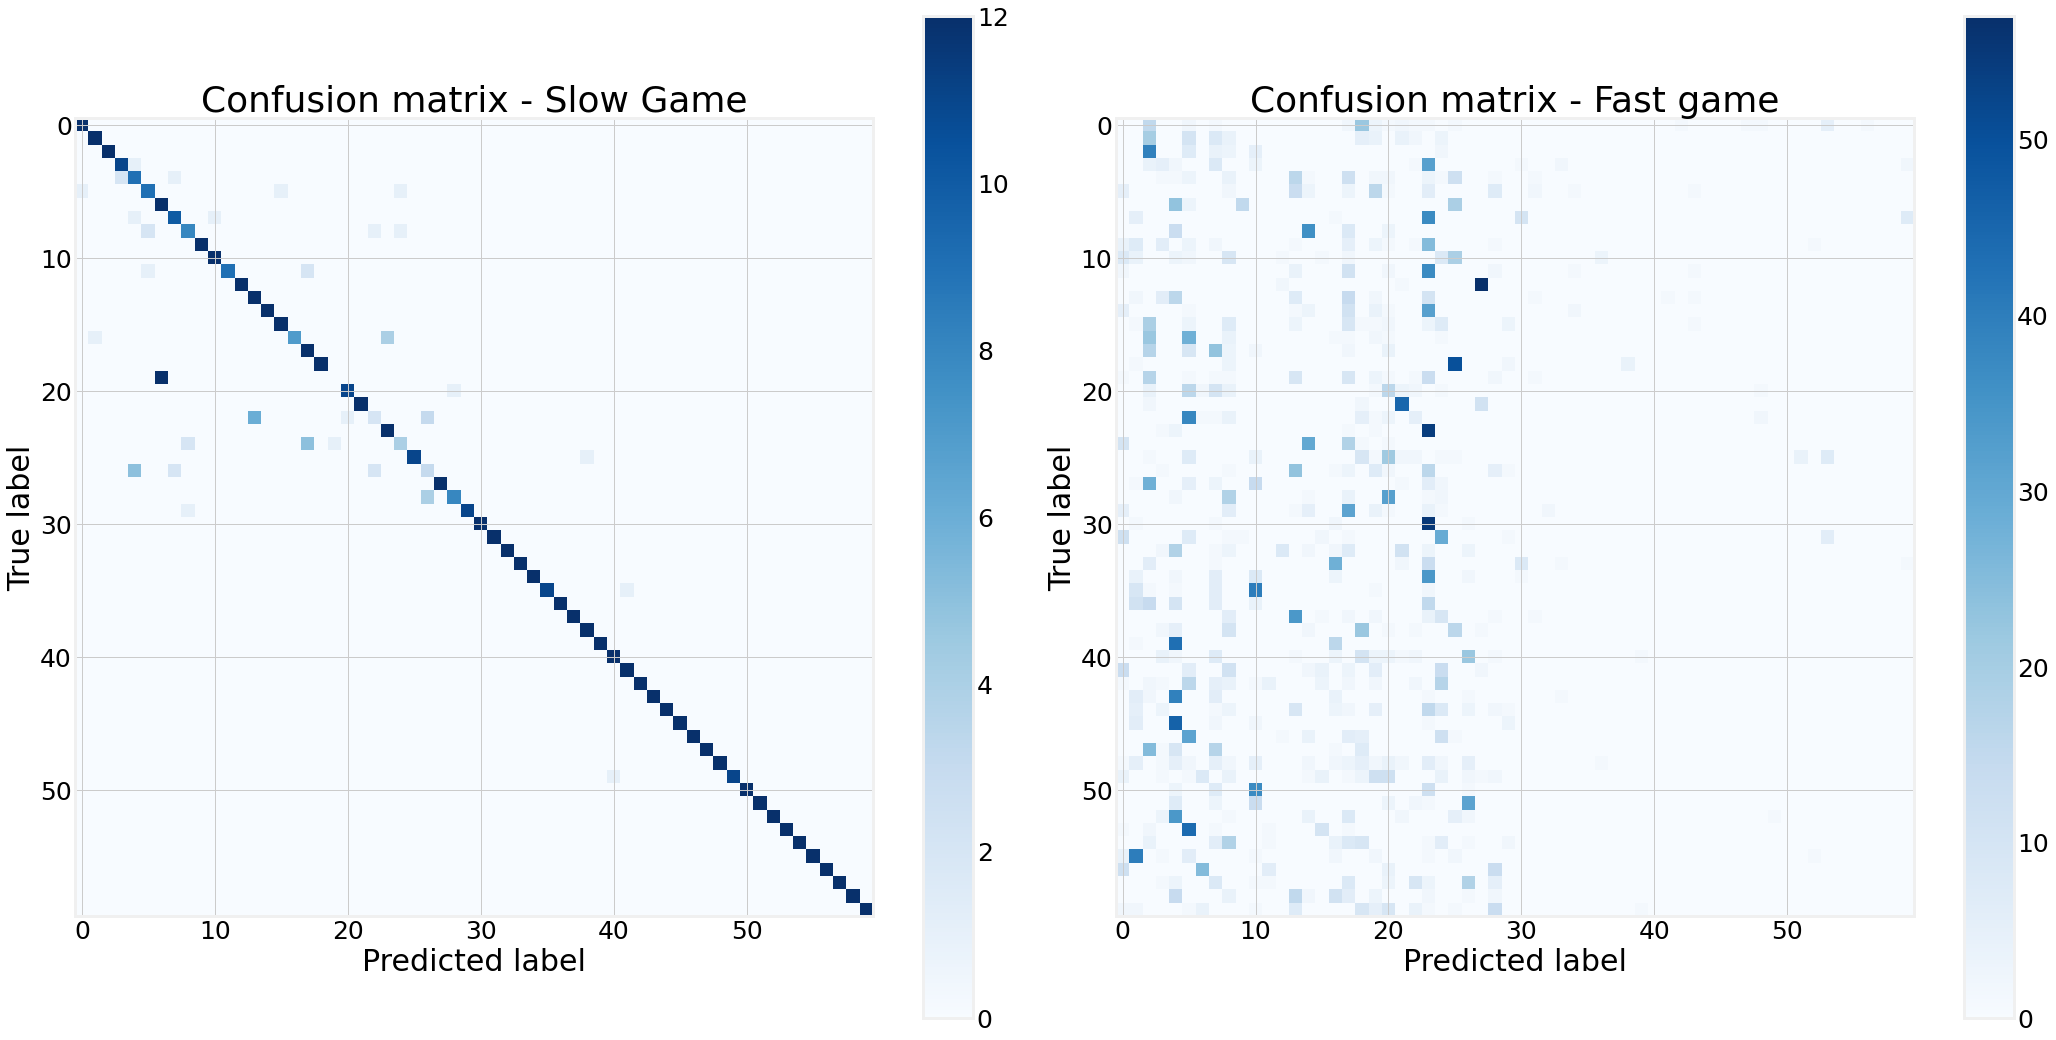

In [8]:
# Setup for plotting two plots side by side (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(30, 15))  # Adjusted figsize to accommodate both plots side by side

# Plotting the first confusion matrix
im1 = ax[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax[0].set_title('Confusion matrix - Slow Game')
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
fig.colorbar(im1, ax=ax[0])

# Calculating the second confusion matrix
cm2 = confusion_matrix(fast_y, best_model.predict(fast_X))

# Plotting the second confusion matrix
im2 = ax[1].imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
ax[1].set_title('Confusion matrix - Fast game')
ax[1].set_ylabel('True label')
ax[1].set_xlabel('Predicted label')
fig.colorbar(im2, ax=ax[1])

plt.tight_layout()  
plt.show()


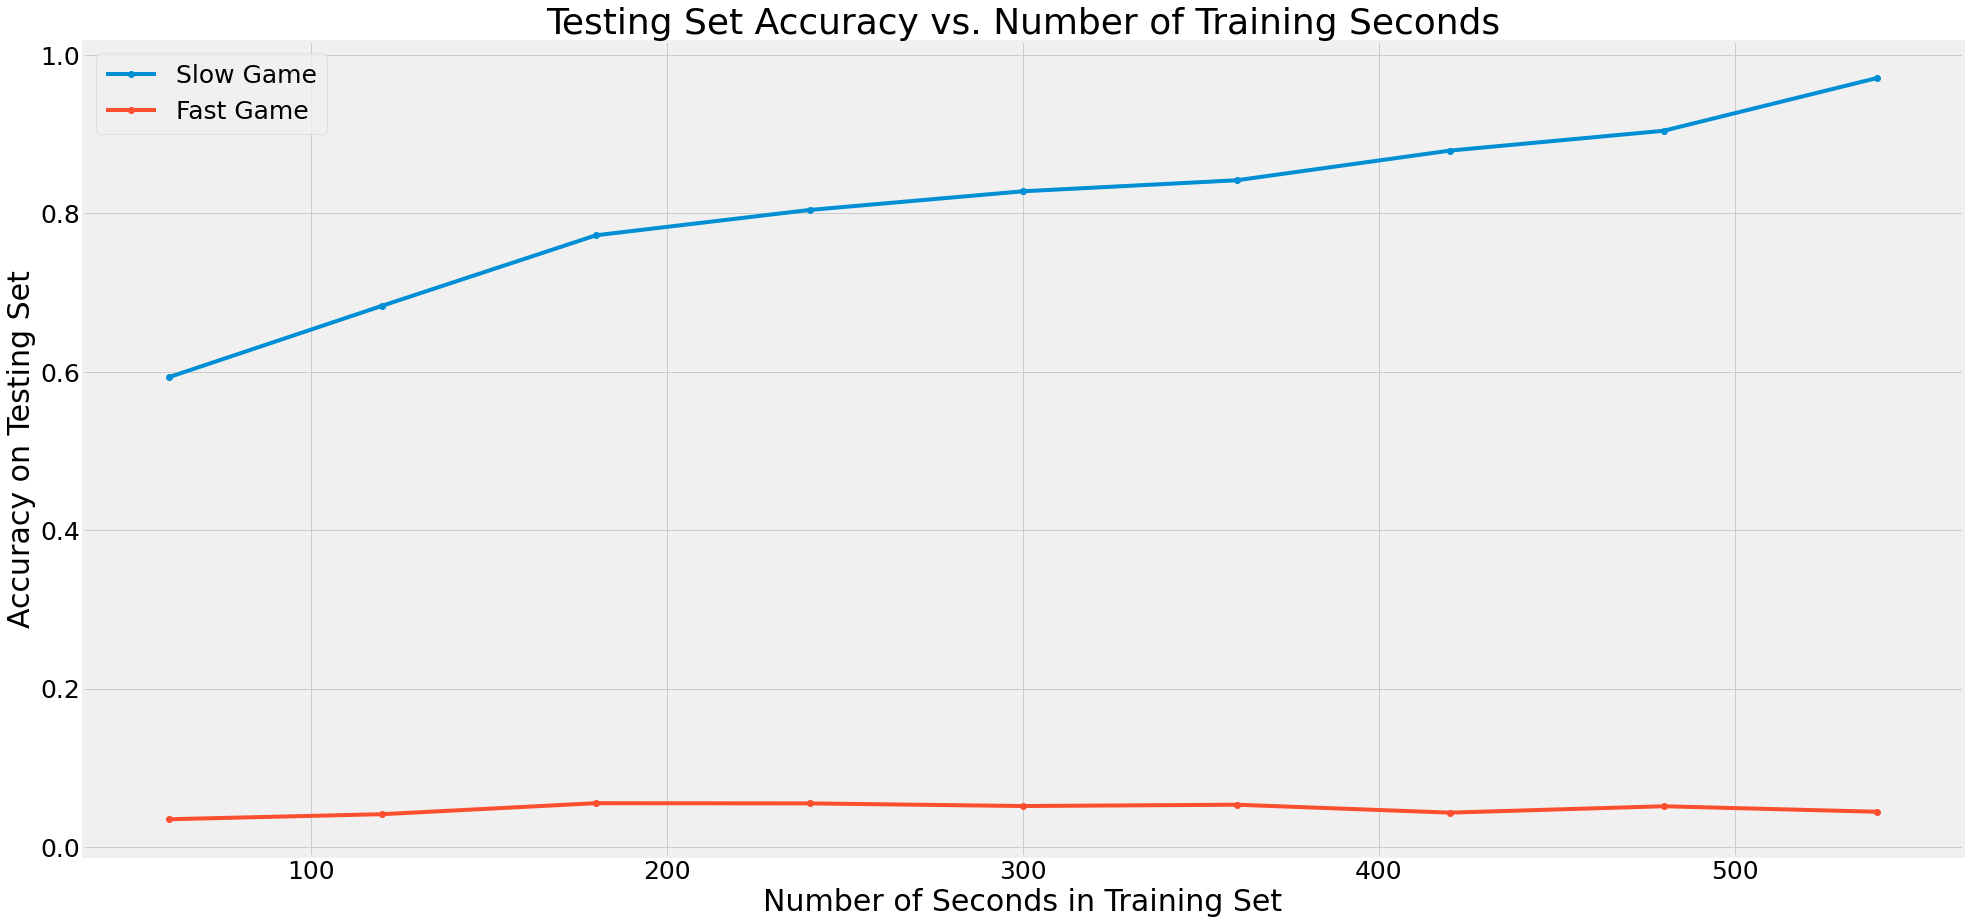

In [9]:
def train_with_increasing_minutes(X, y, unique_minutes, X_test, y_test, fast_X, fast_y):
    accuracies_slow = []
    accuracies_fast = []
    minutes_range = range(1, len(unique_minutes))

    for max_minute in minutes_range:
        selected_minutes = unique_minutes[:max_minute]
        X_train = X[X['time_interval'].isin(selected_minutes)]
        y_train = y[X['time_interval'].isin(selected_minutes)]
        
        # Remove 'time_interval' column for training and testing
        X_train_filtered = X_train.drop(columns=['time_interval'])
        
        model = ExtraTreesClassifier(random_state=42)
        model.fit(X_train_filtered, y_train)
        
        # Test accuracy
        y_pred = model.predict(X_test)
        y_pred_fast = model.predict(fast_X)
        accuracies_slow.append(accuracy_score(y_test, y_pred))
        accuracies_fast.append(accuracy_score(fast_y, y_pred_fast))
    
    # Plotting
    plt.figure(figsize=(30, 15))
    plt.plot(np.array(minutes_range)*60, accuracies_slow, marker='o', linestyle='-', label = "Slow Game")
    plt.plot(np.array(minutes_range)*60, accuracies_fast, marker='o', linestyle='-', label = "Fast Game")
    plt.title('Testing Set Accuracy vs. Number of Training Seconds')
    plt.xlabel('Number of Seconds in Training Set')
    plt.ylabel('Accuracy on Testing Set')
    plt.legend()
    plt.show()

train_with_increasing_minutes(X, y, unique_minutes, X_test, y_test, fast_X, fast_y)

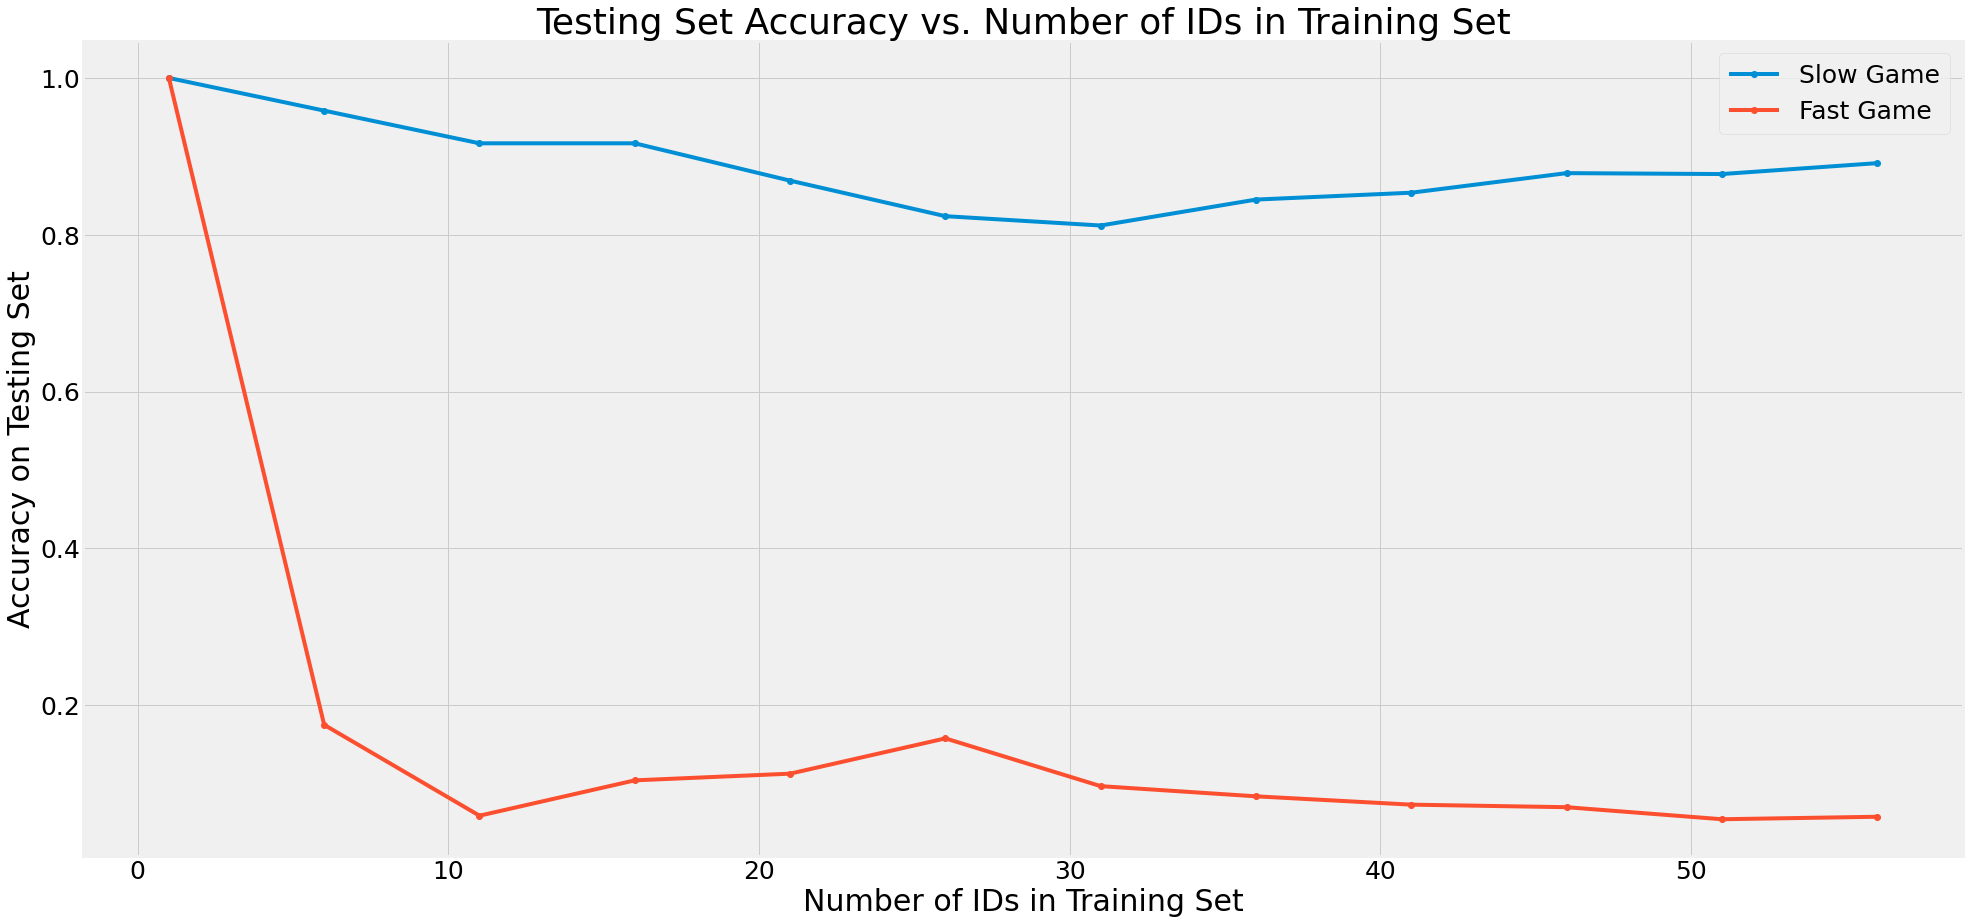

In [10]:
def train_with_increasing_ids(X, y, X_test, y_test, fast_X, fast_y):
    unique_ids = np.sort(y.unique())
    accuracies_slow = []
    accuracies_fast = []
    id_ranges = range(1, len(unique_ids),5)  
    for num_ids in id_ranges:
        selected_ids = unique_ids[:num_ids]
        model = ExtraTreesClassifier(random_state=42)
        model.fit(X[y.isin(selected_ids)], y[y.isin(selected_ids)])
        
        # Test accuracy
        y_pred = model.predict(X_test[y_test.isin(selected_ids)])
        accuracy_slow = accuracy_score(y_test[y_test.isin(selected_ids)], y_pred)
        accuracies_slow.append(accuracy_slow)

        y_pred_fast = model.predict(fast_X[fast_y.isin(selected_ids)])
        accuracy_fast = accuracy_score(fast_y[fast_y.isin(selected_ids)], y_pred_fast)
        accuracies_fast.append(accuracy_fast)
    
    # Plotting
    plt.figure(figsize=(30, 15))
    plt.plot(id_ranges, accuracies_slow, marker='o', linestyle='-', label = "Slow Game")
    plt.plot(id_ranges, accuracies_fast, marker='o', linestyle='-', label = "Fast Game")
    plt.title('Testing Set Accuracy vs. Number of IDs in Training Set')
    plt.xlabel('Number of IDs in Training Set')
    plt.ylabel('Accuracy on Testing Set')
    plt.legend()
    plt.show()
train_with_increasing_ids(X_train, y_train, X_test, y_test,fast_X, fast_y)

## 3.2. Traffic Data

In [11]:
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0)

In [12]:
X = traffic_slow.drop(columns=['ID'])
y = traffic_slow['ID']
fast_X = traffic_fast.drop(columns=['ID'])
fast_y = traffic_fast['ID']
unique_minutes = traffic_slow['time_interval'].unique()

# Split data based on selected minutes
X_train = X[X['time_interval'].isin(unique_minutes[:8])]
y_train = y[X['time_interval'].isin(unique_minutes[:8])]

X_test = X[X['time_interval'].isin(unique_minutes[8:10])]
y_test = y[X['time_interval'].isin(unique_minutes[8:10])]

# Drop the 'minute' column from X_train and X_test as it's no longer needed for training/testing
X_train = X_train.drop(columns=['time_interval'])
X_test = X_test.drop(columns=['time_interval'])
fast_X = fast_X.drop(columns=['time_interval'])

print("Size of the training set: ", X_train.shape)
print("Size of the slow testing set: ", X_test.shape)
print("Size of the fast testing set: ", fast_X.shape)

Size of the training set:  (2879, 36)
Size of the slow testing set:  (720, 36)
Size of the fast testing set:  (3600, 36)


In [13]:
Accuracy_set, models, best_model,cm = evaluate_classifiers(classifiers, X_train,y_train,X_test,y_test,fast_X,fast_y)
Accuracy_set.sort_values(by='Accuracy(Test)').style.background_gradient(cmap= plt.cm.Blues)

  0%|          | 0/13 [00:00<?, ?it/s]

,Model,Accuracy(Train),Accuracy(Test),Accuracy(Fast),F1(Train),F1(Test),Precision(Train),Precision(Test),Recall(Train),Recall(Test),Log_loss(Train),Log_loss(Test)
12,BernoulliNB,0.023272,0.018056,0.028611,0.023272,0.018056,0.023272,0.018056,0.023272,0.018056,4.069957,4.083251
7,AdaBoostClassifier,0.052796,0.047222,0.054722,0.052796,0.047222,0.052796,0.047222,0.052796,0.047222,3.776729,3.808026
0,SVC,0.208058,0.158333,0.091111,0.208058,0.158333,0.208058,0.158333,0.208058,0.158333,3.898305,3.918818
4,KNeighborsClassifier,0.684960,0.297222,0.097222,0.684960,0.297222,0.684960,0.297222,0.684960,0.297222,0.786028,8.847194
10,LogisticRegression,0.340743,0.359722,0.083611,0.340743,0.359722,0.340743,0.359722,0.340743,0.359722,2.864523,2.754102
3,DecisionTreeClassifier,1.000000,0.418056,0.085833,1.000000,0.418056,1.000000,0.418056,1.000000,0.418056,0.000000,20.099649
6,MLPClassifier,0.590483,0.497222,0.080278,0.590483,0.497222,0.590483,0.497222,0.590483,0.497222,1.702707,1.805744
8,GaussianNB,0.607850,0.504167,0.033333,0.607850,0.504167,0.607850,0.504167,0.607850,0.504167,2.381009,4.014627
1,ExtraTreesClassifier,1.000000,0.554167,0.075278,1.000000,0.554167,1.000000,0.554167,1.000000,0.554167,0.000000,2.084056
5,RandomForestClassifier,1.000000,0.566667,0.071944,1.000000,0.566667,1.000000,0.566667,1.000000,0.566667,0.253108,1.996863


In [15]:
# Inverse of covariance matrices
inv_covmat = [np.linalg.inv(cov_mat) for cov_mat in best_model.covariance_]

# Since each class will have a different covariance matrix, 
# and hence a different inverse covariance matrix, we can't directly compare across classes.
# However, within each class, larger values on the diagonal of the inverse covariance matrix 
# would indicate a feature that has more influence on the separation performed by the QDA for that class.

for index, class_inv_covmat in enumerate(inv_covmat):
    print(f"Feature importance for class {index}:")
    print(np.diag(class_inv_covmat))
    print()
# # Plotting feature importance if the best model is a tree-based model
# feature_importance = best_model.feature_importances_
# feature_names = X_train.columns

# # Create a DataFrame to store feature importance and names
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# # Sort the DataFrame by importance
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# # Select top 50 features
# top_features = importance_df.head(50)

# plt.rcParams.update({'font.size': 25})  
# plt.figure(figsize=(30,30))
# plt.barh(top_features['Feature'], top_features['Importance'])
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Top 50 Feature Importance Plot')
# plt.show()

AttributeError: 'QuadraticDiscriminantAnalysis' object has no attribute 'covariance_'